## Topic Modeling: Latent Dirichlet Allocation with sklearn

### Imports

In [9]:
import warnings
from collections import OrderedDict
from pathlib import Path

import numpy as np
import pandas as pd

# Visualization
from ipywidgets import interact, FloatSlider
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import pyLDAvis
from pyLDAvis.sklearn import prepare

from wordcloud import WordCloud
from termcolor import colored

# spacy for language processing
import spacy

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

# gensim for alternative models
from gensim.models import LdaModel, LdaMulticore
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus

In [10]:
% matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14.0, 8.7)
pyLDAvis.enable_notebook()
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

In [21]:
model_path = Path('results', 'bbc')
data_path = Path('bbc')

## Load BBC data

In [24]:
files = data_path.glob('**/*.txt')
doc_list = []
for i, file in enumerate(files):
    with file.open(encoding='latin1') as f:
        _, topic, file_name = file.parts
        lines = f.readlines()
        heading = lines[0].strip()
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list.append([topic, heading, body])

### Convert to DataFrame

In [25]:
docs = pd.DataFrame(doc_list, columns=['topic', 'heading', 'article'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
topic      2225 non-null object
heading    2225 non-null object
article    2225 non-null object
dtypes: object(3)
memory usage: 52.2+ KB


## Create Train & Test Sets

In [13]:
train_docs, test_docs = train_test_split(docs, 
                                         stratify=docs.topic, 
                                         test_size=50, 
                                         random_state=42)

In [14]:
train_docs.shape, test_docs.shape

((2175, 3), (50, 3))

In [15]:
pd.Series(test_docs.topic).value_counts()

sport            12
business         11
tech              9
entertainment     9
politics          9
Name: topic, dtype: int64

### Vectorize train & test sets

In [71]:
vectorizer = TfidfVectorizer(max_df=.2, 
                             min_df=.01, 
                             stop_words='english')

train_dtm = vectorizer.fit_transform(train_docs.article)
words = vectorizer.get_feature_names()
train_dtm

<2175x2899 sparse matrix of type '<class 'numpy.float64'>'
	with 204945 stored elements in Compressed Sparse Row format>

In [72]:
test_dtm = vectorizer.transform(test_docs.article)
test_dtm

<50x2899 sparse matrix of type '<class 'numpy.float64'>'
	with 4759 stored elements in Compressed Sparse Row format>

### LDA with sklearn

In [73]:
n_components = 5
topic_labels = ['Topic {}'.format(i) for i in range(1, n_components+1)]

In [74]:
lda_base = LatentDirichletAllocation(n_components=n_components,
                                     n_jobs=-1,
                                     learning_method='batch',
                                     max_iter=10)
lda_base.fit(train_dtm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

#### Persist model

In [75]:
joblib.dump(lda_base, model_path / 'lda_10_iter.pkl')

['results/bbc/lda_10_iter.pkl']

In [76]:
lda_base = joblib.load(model_path / 'lda_10_iter.pkl') 
lda_base

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

### Explore topics & word distributions

In [77]:
# pseudo counts
topics_count = lda_base.components_
print(topics_count.shape)
topics_count[:5]

(5, 2899)


array([[10.89755488,  5.52927111,  2.23983778, ...,  1.10221562,
        11.60000505,  0.28696128],
       [ 1.18566065,  0.21740574,  0.206715  , ...,  0.21677704,
         0.20001463,  0.20971453],
       [ 0.900682  ,  0.97863379,  0.20157376, ...,  0.53020278,
         0.20001287,  0.20007691],
       [ 3.81555268,  3.41647011,  0.27039661, ...,  1.31884806,
         0.20004654,  0.42003084],
       [ 6.29660707,  1.14085366,  2.18892165, ...,  1.1425963 ,
         0.20000538,  5.37770591]])

In [78]:
topics_prob = topics_count / topics_count.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T,
                      index=words,
                      columns=topic_labels)
topics.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
10,0.00,0.00,0.00,0.00,0.00
100,0.00,0.00,0.00,0.00,0.00
100m,0.00,0.00,0.00,0.00,0.00
11,0.00,0.00,0.00,0.00,0.00
12,0.00,0.00,0.00,0.00,0.00


In [79]:
# all words have positive probability for all topics
topics[topics.gt(0).all(1)].shape[0] == topics.shape[0]

True

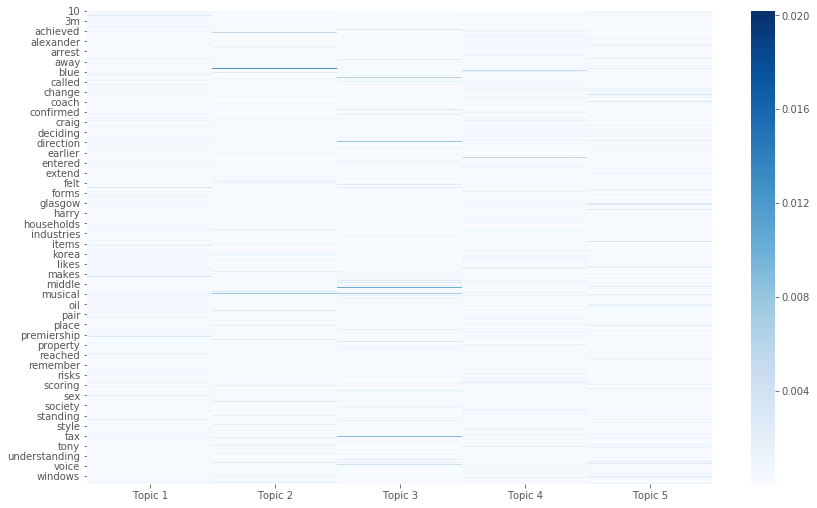

In [80]:
sns.heatmap(topics, cmap='Blues');

In [81]:
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(10).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,company,film,mobile,labour,game
1,market,best,users,election,england
2,sales,awards,software,party,win
3,2004,award,technology,blair,club
4,growth,music,digital,brown,play
5,firm,band,phone,minister,team
6,bank,album,computer,public,match
7,oil,star,music,eu,cup
8,economy,actor,net,howard,players
9,shares,festival,broadband,prime,injury


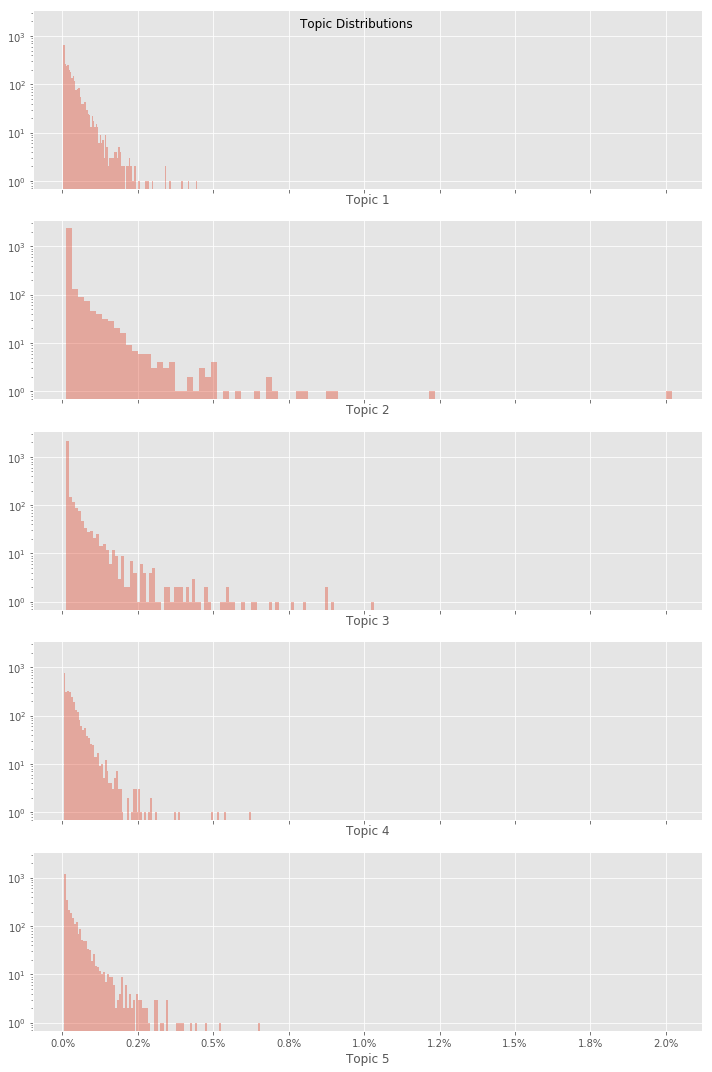

In [82]:
fig, axes = plt.subplots(nrows=5, sharey=True, sharex=True, figsize=(10, 15))
for i, (topic, prob) in enumerate(topics.items()):
    sns.distplot(prob, ax=axes[i], bins=100, kde=False, norm_hist=False)
    axes[i].set_yscale('log')
    axes[i].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
fig.suptitle('Topic Distributions')
fig.tight_layout()

### Evaluate Fit on Train Set

In [83]:
train_preds = lda_base.transform(train_dtm)
train_preds.shape

(2175, 5)

In [84]:
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_docs.topic)
train_eval.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
topic,,,,,
entertainment,0.03,0.03,0.03,0.89,0.03
tech,0.22,0.02,0.72,0.02,0.02
entertainment,0.17,0.45,0.03,0.03,0.33
business,0.91,0.02,0.02,0.02,0.02
sport,0.91,0.02,0.03,0.02,0.02


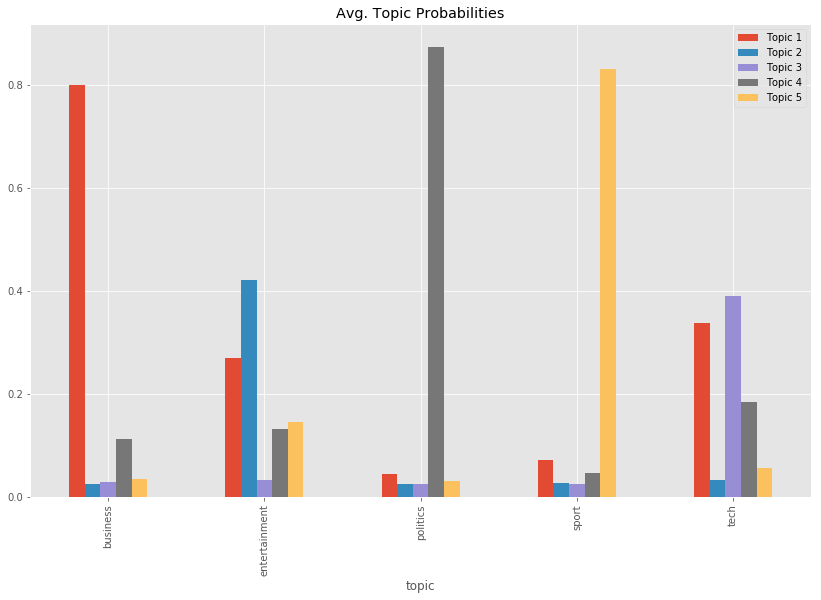

In [85]:
train_eval.groupby(level='topic').mean().plot.bar(title='Avg. Topic Probabilities');

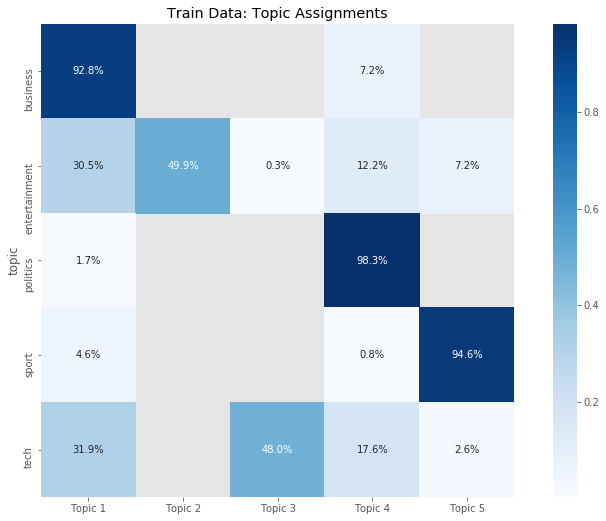

In [86]:
df = train_eval.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True)
sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Train Data: Topic Assignments');

### Evaluate Fit on Test Set 

In [87]:
test_preds = lda_base.transform(test_dtm)
test_eval = pd.DataFrame(test_preds, columns=topic_labels, index=test_docs.topic)
test_eval.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
topic,,,,,
entertainment,0.03,0.53,0.03,0.03,0.38
tech,0.03,0.03,0.28,0.64,0.03
tech,0.36,0.07,0.11,0.02,0.44
business,0.72,0.02,0.02,0.22,0.02
sport,0.02,0.02,0.02,0.02,0.91


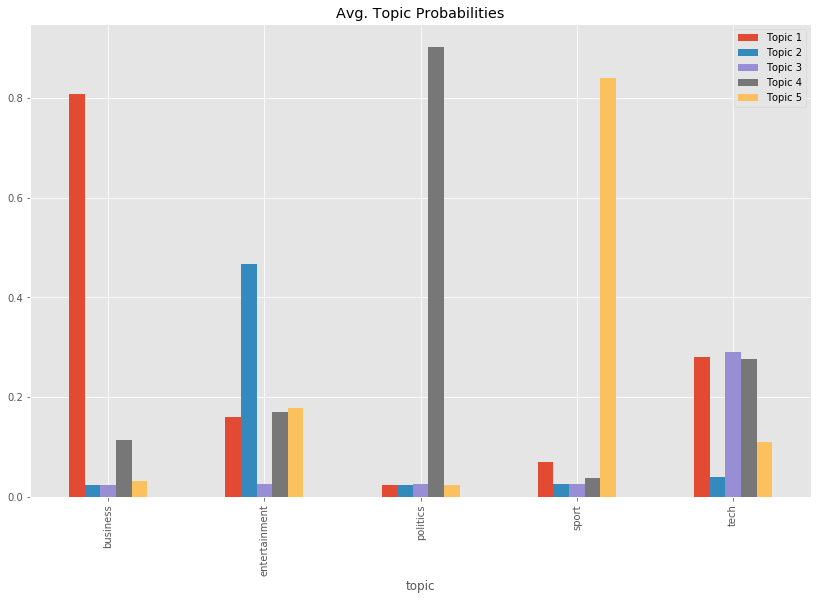

In [88]:
test_eval.groupby(level='topic').mean().plot.bar(title='Avg. Topic Probabilities');

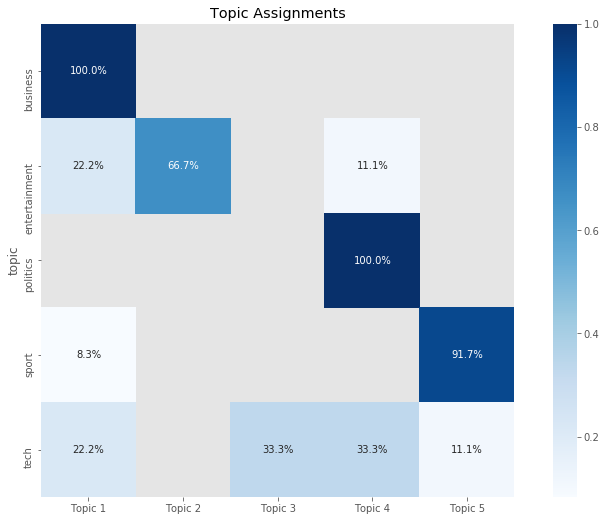

In [89]:
df = test_eval.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True)
sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Topic Assignments');

### Retrain until perplexity no longer decreases

In [90]:
lda_opt = LatentDirichletAllocation(n_components=5, 
                                    n_jobs=-1, 
                                    max_iter=500,
                                    learning_method='batch', 
                                    evaluate_every=5,
                                    verbose=1, 
                                    random_state=42)
lda_opt.fit(train_dtm)

iteration: 1 of max_iter: 500
iteration: 2 of max_iter: 500
iteration: 3 of max_iter: 500
iteration: 4 of max_iter: 500
iteration: 5 of max_iter: 500, perplexity: 5307.4876
iteration: 6 of max_iter: 500
iteration: 7 of max_iter: 500
iteration: 8 of max_iter: 500
iteration: 9 of max_iter: 500
iteration: 10 of max_iter: 500, perplexity: 5138.1714
iteration: 11 of max_iter: 500
iteration: 12 of max_iter: 500
iteration: 13 of max_iter: 500
iteration: 14 of max_iter: 500
iteration: 15 of max_iter: 500, perplexity: 5053.3613
iteration: 16 of max_iter: 500
iteration: 17 of max_iter: 500
iteration: 18 of max_iter: 500
iteration: 19 of max_iter: 500
iteration: 20 of max_iter: 500, perplexity: 4979.2082
iteration: 21 of max_iter: 500
iteration: 22 of max_iter: 500
iteration: 23 of max_iter: 500
iteration: 24 of max_iter: 500
iteration: 25 of max_iter: 500, perplexity: 4942.3991
iteration: 26 of max_iter: 500
iteration: 27 of max_iter: 500
iteration: 28 of max_iter: 500
iteration: 29 of max_iter:

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=5, learning_decay=0.7, learning_method='batch',
             learning_offset=10.0, max_doc_update_iter=100, max_iter=500,
             mean_change_tol=0.001, n_components=5, n_jobs=-1,
             n_topics=None, perp_tol=0.1, random_state=42,
             topic_word_prior=None, total_samples=1000000.0, verbose=1)

In [91]:
joblib.dump(lda_opt, model_path / 'lda_opt.pkl')

['results/bbc/lda_opt.pkl']

In [92]:
lda_opt = joblib.load(model_path / 'lda_opt.pkl')

In [93]:
train_opt_eval = pd.DataFrame(data=lda_opt.transform(train_dtm),
                              columns=topic_labels,
                              index=train_docs.topic)

In [94]:
test_opt_eval = pd.DataFrame(data=lda_opt.transform(test_dtm),
                             columns=topic_labels, 
                             index=test_docs.topic)

### Compare Train & Test Topic Assignments 

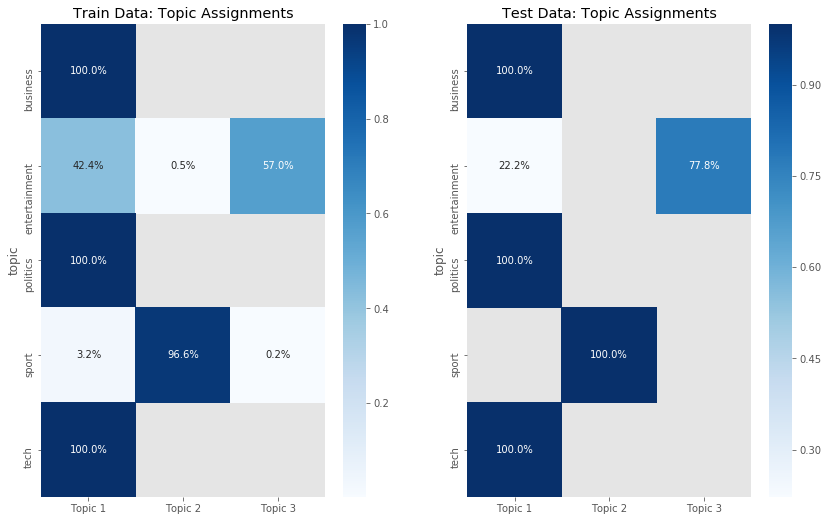

In [95]:
fig, axes = plt.subplots(ncols=2)
source = ['Train', 'Test']
for i, df in enumerate([train_opt_eval, test_opt_eval]):
    df = df.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True)
    sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True, ax=axes[i])
    axes[i].set_title('{} Data: Topic Assignments'.format(source[i]));

### Explore misclassified articles 

In [96]:
test_assignments = test_opt_eval.groupby(level='topic').idxmax(axis=1)
test_assignments = test_assignments.reset_index(-1, drop=True).to_frame('predicted').reset_index()
test_assignments['heading'] = test_docs.heading.values
test_assignments['article'] = test_docs.article.values
test_assignments.head()

,topic,predicted,heading,article
0,business,Topic 1,Brits return Keane to number one,Brits success has helped return Keane's award...
1,business,Topic 1,Anti-spam screensaver scrapped,A contentious campaign to bump up the bandwid...
2,business,Topic 1,The Force is strong in Battlefront,The warm reception that has greeted Star Wars...
3,business,Topic 1,"Rover deal 'may cost 2,000 jobs'","Some 2,000 jobs at MG Rover's Midlands plant ..."
4,business,Topic 1,Sculthorpe wants Lions captaincy,Paul Sculthorpe has admitted he would love to...


In [97]:
misclassified = test_assignments[(test_assignments.topic == 'business') & (
    test_assignments.predicted == 'Topic 3')]
misclassified.heading

Series([], Name: heading, dtype: object)

In [98]:
misclassified.article.tolist()

[]

### PyLDAVis

LDAvis helps you interpret LDA results by answer 3 questions:

1. What is the meaning of each topic?
2. How prevalent is each topic?
3. How do topics relate to each other?

#### Refit using all data

In [99]:
vectorizer = CountVectorizer(max_df=.5, 
                             min_df=5,
                             stop_words='english',
                             max_features=2000)
dtm = vectorizer.fit_transform(docs.article)

In [100]:
lda_all = LatentDirichletAllocation(n_components=5,
                                    max_iter=500,
                                    learning_method='batch',
                                    evaluate_every=10,
                                    random_state=42,
                                    verbose=1)
lda_all.fit(dtm)

iteration: 1 of max_iter: 500
iteration: 2 of max_iter: 500
iteration: 3 of max_iter: 500
iteration: 4 of max_iter: 500
iteration: 5 of max_iter: 500
iteration: 6 of max_iter: 500
iteration: 7 of max_iter: 500
iteration: 8 of max_iter: 500
iteration: 9 of max_iter: 500
iteration: 10 of max_iter: 500, perplexity: 1022.6552
iteration: 11 of max_iter: 500
iteration: 12 of max_iter: 500
iteration: 13 of max_iter: 500
iteration: 14 of max_iter: 500
iteration: 15 of max_iter: 500
iteration: 16 of max_iter: 500
iteration: 17 of max_iter: 500
iteration: 18 of max_iter: 500
iteration: 19 of max_iter: 500
iteration: 20 of max_iter: 500, perplexity: 1007.1868
iteration: 21 of max_iter: 500
iteration: 22 of max_iter: 500
iteration: 23 of max_iter: 500
iteration: 24 of max_iter: 500
iteration: 25 of max_iter: 500
iteration: 26 of max_iter: 500
iteration: 27 of max_iter: 500
iteration: 28 of max_iter: 500
iteration: 29 of max_iter: 500
iteration: 30 of max_iter: 500, perplexity: 1003.1695
iteration:

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=10, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=500, mean_change_tol=0.001,
             n_components=5, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=1)

In [101]:
joblib.dump(lda_all, model_path /'lda_all.pkl')

['results/bbc/lda_all.pkl']

In [102]:
lda_all = joblib.load(model_path / 'lda_all.pkl') 

#### Lambda

- **$\lambda$ = 0**: how probable is a word to appear in a topic - words are ranked on lift P(word | topic) / P(word)
- **$\lambda$ = 1**: how exclusive is a word to a topic -  words are purely ranked on P(word | topic)

The ranking formula is $\lambda * P(\text{word} \vert \text{topic}) + (1 - \lambda) * \text{lift}$

User studies suggest $\lambda = 0.6$ works for most people.

In [103]:
prepare(lda_all, dtm, vectorizer)

PreparedData(topic_coordinates=       Freq  cluster  topics     x     y
topic                                   
2     25.51        1       1  0.07  0.08
3     21.82        1       2  0.09 -0.10
0     20.96        1       3  0.14  0.01
4     18.70        1       4 -0.14  0.14
1     13.01        1       5 -0.17 -0.13, topic_info=     Category     Freq        Term    Total  loglift  logprob
term                                                         
1200  Default 2,987.00          mr 2,987.00    30.00    30.00
724   Default   838.00        film   838.00    29.00    29.00
230   Default   960.00        best   960.00    28.00    28.00
1022  Default   770.00      labour   770.00    27.00    27.00
780   Default   855.00        game   855.00    26.00    26.00
817   Default 1,151.00  government 1,151.00    25.00    25.00
1206  Default   810.00       music   810.00    24.00    24.00
619   Default   630.00    election   630.00    23.00    23.00
1305  Default   624.00       party   624.00    22.00    22.00
1177  Default   521.00      mobile   521.00    21.00    21.00
1788  Default   553.00  technology   553.00    20.00    20.00
240   Default   551.00       blair   551.00    19.00    19.00
631   Default   593.00     england   593.00    18.00    18.00
1319  Default 2,030.00      people 2,030.00    17.00    17.00
1129  Default   683.00      market   683.00    16.00    16.00
1884  Default   406.00       users   406.00    15.00    15.00
551   Default   404.00     digital   404.00    14.00    14.00
195   Default   291.00      awards   291.00    13.00    13.00
194   Default   280.00       award   280.00    12.00    12.00
1658  Default   373.00    software   373.00    11.00    11.00
205   Default   360.00        bank   360.00    10.00    10.00
832   Default   443.00      growth   443.00     9.00     9.00
1170  Default   552.00    minister   552.00     8.00     8.00
1329  Default   373.00       phone   373.00     7.00     7.00
1968  Default   589.00         won   589.00     6.00     6.00
403   Default   678.00     company   678.00     5.00     5.00
1346  Default   513.00     players   513.00     4.00     4.00
1957  Default   580.00         win   580.00     3.00     3.00
380   Default   364.00        club   364.00     2.00     2.00
608   Default   421.00     economy   421.00     1.00     1.00
...       ...      ...         ...      ...      ...      ...
575    Topic5    56.72      doping    57.52     2.03    -6.48
387    Topic5   130.06      comedy   131.91     2.03    -5.65
724    Topic5   818.47        film   838.10     2.02    -3.81
1661   Topic5   171.90        song   177.54     2.01    -5.38
204    Topic5   211.33        band   223.18     1.99    -5.17
1395   Topic5   148.73       prize   158.69     1.97    -5.52
325    Topic5   102.17    ceremony   107.12     1.99    -5.90
1705   Topic5   127.00       stars   137.86     1.96    -5.68
1703   Topic5   249.12        star   292.57     1.88    -5.00
230    Topic5   698.84        best   960.17     1.72    -3.97
1456   Topic5   101.37         ray   108.11     1.98    -5.90
725    Topic5   211.01       films   254.01     1.85    -5.17
316    Topic5    95.88    category   102.16     1.98    -5.96
1206   Topic5   404.05       music   810.44     1.34    -4.52
1194   Topic5   127.67       movie   158.77     1.82    -5.67
1968   Topic5   290.56         won   589.23     1.33    -4.85
556    Topic5   230.87    director   426.78     1.43    -5.08
266    Topic5   224.16     british   533.06     1.17    -5.11
920    Topic5   182.56   including   404.97     1.24    -5.31
1238   Topic5   228.73      number   748.61     0.85    -5.09
1992   Topic5   232.24       years   991.66     0.59    -5.07
1224   Topic5   285.88         new 1,896.89     0.15    -4.87
1863   Topic5   176.87          tv   481.87     1.04    -5.35
1866   Topic5   210.95          uk 1,047.95     0.44    -5.17
216    Topic5   162.82         bbc   747.90     0.52    -5.43
1081   Topic5   145.36      london   454.66     0.90    -5.54
1816   Topic

### Topics as WordClouds

In [104]:
topics_prob = lda_all.components_ / lda_all.components_.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T,
                      index=vectorizer.get_feature_names(),
                      columns=topic_labels)

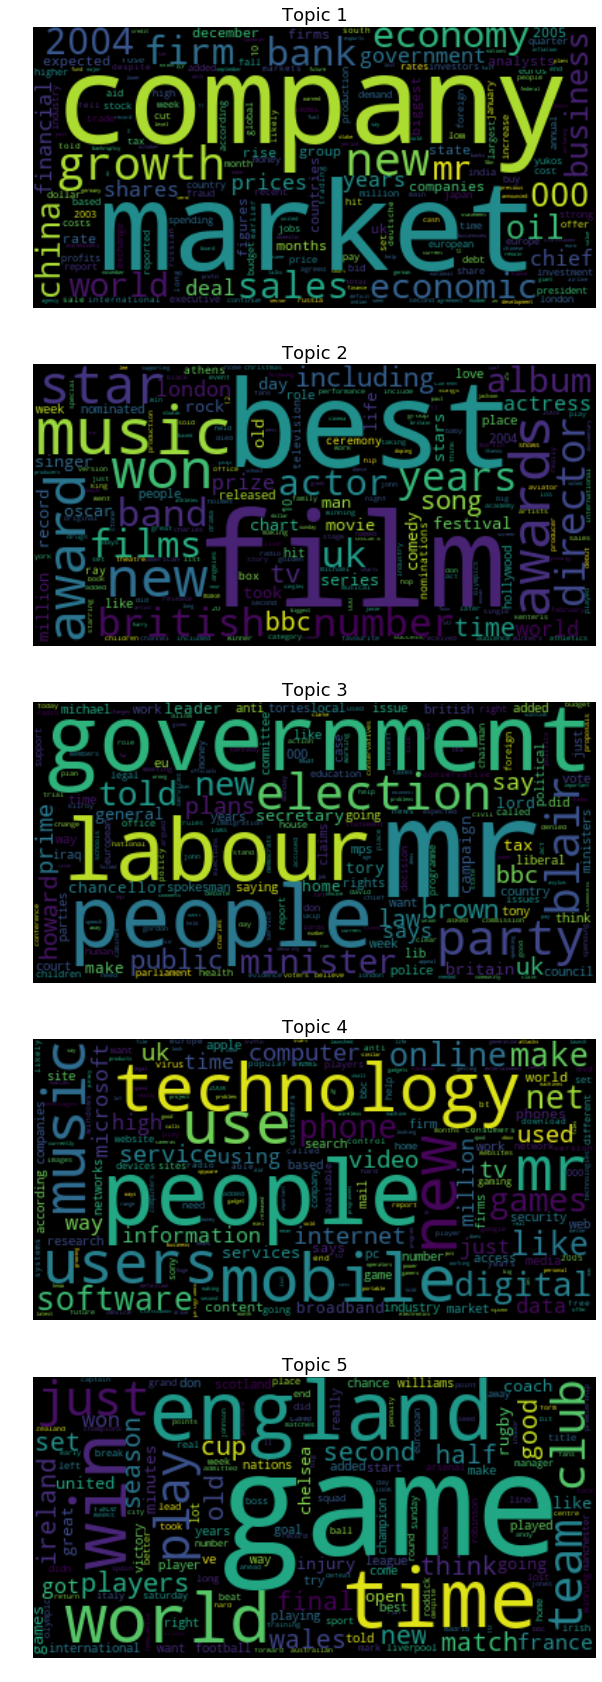

In [105]:
w = WordCloud()
fig, axes = plt.subplots(nrows=5, figsize=(15, 30))
axes = axes.flatten()
for t, (topic, freq) in enumerate(topics.items()):
    w.generate_from_frequencies(freq.to_dict())
    axes[t].imshow(w, interpolation='bilinear')
    axes[t].set_title(topic, fontsize=18)
    axes[t].axis('off')

### Visualize topic-word assocations per document

In [106]:
dtm_ = pd.DataFrame(data=lda_all.transform(dtm),
                    columns=topic_labels,
                    index=docs.topic)

In [107]:
color_dict = OrderedDict()
color_dict['Topic 1'] = {'color': 'white', 'on_color': 'on_blue'}
color_dict['Topic 2'] = {'color': 'white', 'on_color': 'on_green'}
color_dict['Topic 3'] = {'color': 'white', 'on_color': 'on_red'}
color_dict['Topic 4'] = {'color': 'white', 'on_color': 'on_magenta'}
color_dict['Topic 5'] = {'color': 'blue', 'on_color': 'on_yellow'}

In [108]:
dtm_['article'] = docs.article.values
dtm_['heading'] = docs.heading.values
sample = dtm_[dtm_[topic_labels].gt(.1).all(1)]
sample

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,article,heading
topic,,,,,,,
entertainment,0.14,0.28,0.23,0.23,0.11,Women in the UK film industry earn less than ...,Women in film 'are earning less'


In [109]:
colored_text = []
for word in sample.iloc[0, 5].split():
    try:
        topic = topics.loc[word.strip().lower()].idxmax()
        colored_text.append(colored(word, **color_dict[topic]))
    except:
        colored_text.append(word)
    ®
print(' '.join([colored(k, **v) for k, v in color_dict.items()]))
print('\n',sample.iloc[0, 6], '\n')
text = ' '.join(colored_text)
print(text)

SyntaxError: invalid character in identifier (<ipython-input-109-1d47abaf1089>, line 8)